In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from astropy.table import Table
import corner

In [2]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import statistics_ as sta
import mcmc as mcmc_

# Creating fake data assuming a model

We set the true parameters

In [3]:
ptrue = [2,50]

We define the model

In [4]:
def model_MCMC(X,p):
    
    x = X[0]
    
    return p[0]*x**2 + p[1]

We create fake data described by the above model introducing fake noise

In [5]:
N = 10
noise = 1
xdimension = 1
x = np.linspace(-0,10,N)
Xdata = [x]
X = mcmc_.combinatory(Xdata)
y_exp = model_MCMC(X,ptrue) + np.random.randn(N**xdimension)*noise

We store the `x` data and `y` measured data in an `astropy` table

In [6]:
t = Table()
t['x0'] = X[0]
t['y'] = y_exp

# Covariance Matrix

We create arbitrary covariance matrix

In [7]:
Stat = sta.Statistics(N)

In [8]:
n_repet = 100
for i in range(n_repet):
    
    y_real = model_MCMC([t['x0']],ptrue) + np.random.randn(N**xdimension)*noise
    
    Stat._add_realization(y_real)

In [22]:
Stat.estimate_covariance()
cov = Stat.covariance_matrix/(n_repet - 1)

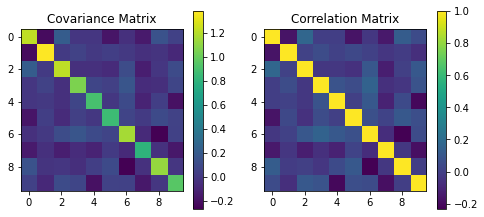

In [23]:
fig = plt.figure(figsize = (8,8))
plt.subplot(221)
plt.imshow(cov)
plt.title('Covariance Matrix')
plt.colorbar()

plt.subplot(222)
Stat.estimate_correlation()
corr = Stat.correlation_matrix
plt.imshow(corr)
plt.title('Correlation Matrix')
plt.colorbar()
plt.show()

# Fit parameters using MCMC

In [ ]:
MCMC = mcmc_.MCMC(n_parameters = 2)

We add data information to the `MCMC` object

In [ ]:
MCMC._set_data(t)
MCMC._set_covariance_matrix(cov)
MCMC._set_model(model_MCMC)

We set bounds for parameter space

In [ ]:
MCMC._set_lnprior_bounds(bounds = [[-5,5],[-5,100] ])

We intitialize the random walks and find out the stating point of the official random walks by running first short MCMC

In [ ]:
MCMC._set_walkers(n_walkers = 100, n_step = 200)
MCMC._set_initial_condition(np.array([1,1]), np.array([0.1,0.1]))
MCMC.run_MCMC()
MCMC._discard(tau = 50)
MCMC.fit_symmetric()

Second, we run last MCMC with intitial position estimated above

In [ ]:
MCMC._set_walkers(n_walkers = 200, n_step = 500)
MCMC._set_initial_condition(MCMC.mean_symmetric, MCMC.error_symmetric)
MCMC.run_MCMC()

In [ ]:
MCMC._discard(tau = 100)

We plot the corner plot to display the last sample

In [ ]:
from corner import corner
fig = plt.figure()
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
fig = corner(MCMC.samples\
             ,reverse = False,\
            bins = 30,\
             smooth = True,\
             plot_datapoints=False,levels=(sigma1, sigma2), \
             #labels =use_params,\
             quantiles=[0.16, 0.5, 0.84], \
             color='k',\
             #range = use_ranges,\
         show_titles = True, \
        truths =np.array(ptrue),\
         truth_color='r', smooth1d = 1, top_ticks = True)

## There is two ways to estimate parameters:

Using MCMC assymmetry due to true PDF of parameters:

In [ ]:
MCMC.fit_MCMC()
popt, cov = MCMC.mean_MCMC, MCMC.error_MCMC
print('x = ' + str(popt) + ' +/- ' + str(cov))

Using mean and covariance matrix:

In [ ]:
MCMC.fit_symmetric()
popt, cov = MCMC.mean_symmetric, MCMC.error_symmetric
print('x = ' + str(popt) + ' +/- ' + str(cov))